In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.special import legendre, factorial,eval_legendre
from pandas import *
from scipy.optimize import fsolve
from scipy.special import hankel2
from scipy.interpolate import interp1d,spline,BSpline,splrep,splev
from sympy import init_printing, evalf, S,lambdify
from scipy.integrate import quad, odeint
from mpmath import findroot
init_printing()
%matplotlib notebook

In [3]:
def E(n):
    D=np.zeros((n,n),dtype=np.float64)
    dm=np.zeros(n,dtype=np.float64)[:,np.newaxis]
    b=np.zeros(n,dtype=np.float64)
    c=np.array([2/(i+1) for i in range(n)],dtype=np.float64)[:,np.newaxis]
    dm[0]=1/2

    for i in range(n):
        for j in range(n):
            if i==j+1:
                D[i,j]=(1/2)/(i+1)
            if i==j-1:
                D[i,j]=-(1/2)/(i+1)
    
    for i in range(1,n):
        b[i-1]=(-1)**(i+1)*factorial(n+i-1)/(factorial(n-i-1)*factorial(i)**2)
    b[n-1]=(-1)**(n+1)
    
    #for i in range(1,n+1):
        #b[i-1]=(-1)**(i-1)*factorial(n)/(factorial(i)*factorial(n-i))
        
    dTm=np.transpose(dm)


    E=(D+dm*b+c*dTm+0.5*c*b)
    
    return E,c,b,D,dm

In [4]:
def flutter(U0):
    
    b=0.5
    d=-0.25
    m=40
    Sα=10
    Iα=5.83
    Kξ=8000
    Kα=500
    α0=2*np.pi/180
    ρ=1.225
    EI=500
    
    A=np.zeros((12,12))
    B=np.zeros((12,12))
    C=np.zeros((12))
      
    A[:2,:2]=np.identity(2)
    A[2,2]=m+np.pi*ρ*b**2
    A[2,3]=A[3,2]=Sα-np.pi*ρ*b**2*d
    A[3,3]=Iα+np.pi*ρ*b**2*(1/8*b**2+d**2)
    A[4:,4:]=E(8)[0]#*U0
    A[4:,2]=-E(8)[1][:,0]
    A[4:,3]=-E(8)[1][:,0]*(0.5*b-d)
    
    B[0,2]=B[1,3]=1
    B[2,0]=-Kξ
    B[2,1]=-2*np.pi*ρ*b*U0**2
    B[3,1]=-Kα+2*np.pi*ρ*b*U0**2*(0.5*b+d)    
    B[2,2]=-2*np.pi*ρ*b*U0    
    B[2,3]=-np.pi*ρ*b**2*U0-2*np.pi*ρ*b*U0*(0.5*b-d)
    
    B[3,2]=2*np.pi*ρ*b*U0*(0.5*b+d)
    B[3,3]=2*np.pi*ρ*b*U0*(0.5*b+d)*(0.5*b-d)-np.pi*ρ*b**2*(0.5*b-d)*U0
    B[4:,4:]=-np.identity(8)*U0/b #**2
    B[4:,3]=U0*E(8)[1][:,0]
    
    B[2,4]=2*np.pi*ρ*b*U0#**2#*E(8)[2]*0.5
    B[3,4]=-2*np.pi*ρ*b*U0*(0.5*b+d)#*E(8)[2]*0.5 ##**2
    
    C[3]=Kα*α0
    
    
    D=la.inv(A)@B
    return A,B#la.eig(B,A)
    

In [5]:
DataFrame(flutter(20)[1])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0000,1.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0000,0.00000,1.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8000.0,-1539.3804,-76.96902,-57.726765,76.96902,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-500.0000,0.00000,-9.621128,-0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0000,0.00000,40.000000,-40.00000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,0.0,0.0000,0.00000,20.000000,-0.00000,-40.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,0.0,0.0000,0.00000,13.333333,-0.00000,-0.0,-40.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,0.0,0.0000,0.00000,10.000000,-0.00000,-0.0,-0.0,-40.0,-0.0,-0.0,-0.0,-0.0
8,0.0,0.0000,0.00000,8.000000,-0.00000,-0.0,-0.0,-0.0,-40.0,-0.0,-0.0,-0.0
9,0.0,0.0000,0.00000,6.666667,-0.00000,-0.0,-0.0,-0.0,-0.0,-40.0,-0.0,-0.0


In [6]:
def fluttera(ma,a,xα,rα,U0a,ωξα):
 
  
    A=np.zeros((12,12))
    B=np.zeros((12,12))
    C=np.zeros(12)
    α_0=2*np.pi/180
      
    A[0,0]=A[1,1]=1/(2*np.pi)
    A[2,2]=(1+1/ma)/(2*np.pi)**2
    A[2,3]=A[3,2]=(xα-a/ma)/(2*np.pi)**2
    A[3,3]=((rα)**2+(1/8+(a)**2)/ma)/(2*np.pi)**2
    #A[4:,4:]=E(8)[0]/(2*np.pi)
    A[4:,4:]=E(8)[0]*U0a/(2*np.pi)
    A[4:,2]=-(E(8)[1][:,0])/(2*np.pi)**2
    A[4:,3]=-(E(8)[1][:,0]*(0.5-a))/(2*np.pi)**2
    
    B[0,2]=B[1,3]=1/(2*np.pi)
    
    B[2,0]=-(ωξα)**2
    
    B[2,1]=-2*U0a**2/ma
    
    B[3,1]=-(rα)**2+2*U0a**2*(0.5+a)/ma ###REv    
    
    B[2,2]=-(2*U0a/ma)/(2*np.pi) 
    
    B[2,3]=-(2*U0a*(1-a)/ma)/(2*np.pi) 
    B[3,2]=(2*U0a*(0.5+a)/ma)/(2*np.pi)
    
    B[3,3]=(2*U0a*(0.5+a)*(0.5-a)/ma-(0.5-a)*U0a/ma)/(2*np.pi)
    B[4:,4:]=-np.identity(8)*(U0a)**2
    #B[4:,4:]=-np.identity(8)*U0a
    B[4:,3]=(U0a*E(8)[1][:,0])/(2*np.pi)
    
    #B[2,4]=(2*U0a/ma)
    #B[3,4]=(-2*U0a*(0.5+a)/ma)
    B[2,4]=(2*(U0a)**2/ma)#*E(8)[2]*0.5
    B[3,4]=(-2*(U0a)**2*(0.5+a)/ma)#*E(8)[2]*0.5
    
    C[3]=rα**2*α_0
    
   
    #D=la.inv(A)@B
    return A,B,C,la.eig(B,A)
    #return B

In [7]:
UU=np.linspace(1e-6,4,1000)

In [16]:
fluttera(20,-0.3,0,0.5,3,0.5)[3][0][2:4].imag

array([ 66.61922749, -66.61922749])

In [17]:
fluttera(20,-0.3,0,0.5,3,0.5)[3][0][2:4].real

array([-61.09610281, -61.09610281])

In [18]:
λ=np.zeros((1000,12),dtype=np.complex)
for i in range(1000):
    λ[i]=fluttera(10,-0.2,0.005,0.5,UU[i],0)[3][0]


In [19]:
fluttera(10,-0.2,0.005,0.5,3,0)[3][0]

array([  0.00000000  +0.j        , -43.90591115+157.07959711j,
       -43.90591115-157.07959711j, -61.08874092 +66.64140266j,
       -61.08874092 -66.64140266j, -33.54604130  +0.j        ,
         1.60008541  +2.80190327j,   1.60008541  -2.80190327j,
       -14.41392962  +0.j        ,  -7.88529805  +0.9860855j ,
        -7.88529805  -0.9860855j ,  -0.69162949  +0.j        ])

In [20]:
fluttera(10,-0.2,0.005,0.5,3,0)[0]

array([[  1.59154943e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.59154943e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.78633255e-02,
          6.33257398e-04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   6.33257398e-04,
          6.75052386e-03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
    

In [21]:
fluttera(10,-0.2,0.005,0.5,3,0)[0]/fluttera(10,-0.2,0.005,0.5,3,0)[0][6]

C:\Users\Jesus\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\Jesus\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[        inf,         nan, -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        ],
       [        nan,         inf, -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        ],
       [        nan,         nan, -1.65      , -0.05357143,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        ],
       [        nan,         nan, -0.0375    , -0.57107143,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        ],
       [        nan,         nan,  3.        ,  3.        ,  4.47368421,
         4.5049636 ,  4.5       ,  4.4998052 ,  4.5       ,  4.5       ,
         4.5       ,  4.5       ],
       [        nan,         nan,  1.5       ,  1.5       ,  1.51315789,
         1.50099272,  

<IPython.core.display.Javascript object>


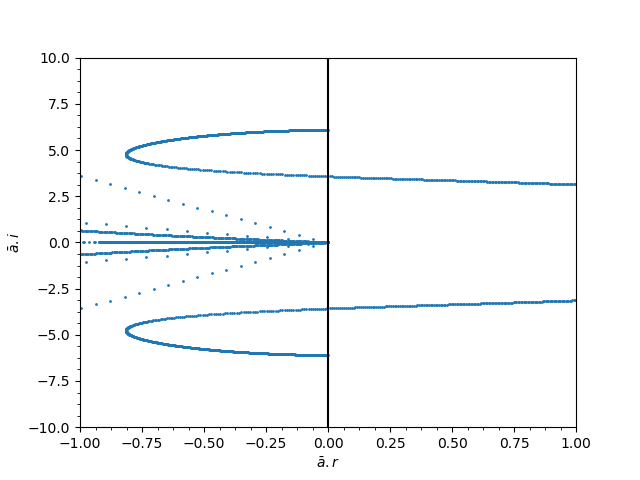

In [24]:
plt.figure()
plt.scatter(λ.real,λ.imag,s=1)
plt.axvline(0,color='black')
plt.xlim(-1,1)
plt.ylim(-10,10)
plt.ylabel(r'$\bar{a}.i$')
plt.xlabel(r'$\bar{a}.r$')
plt.minorticks_on()
plt.savefig('autovalores',dpi=300)

In [300]:
#fluttera(ma,a,xα,rα,U0a,ωξα)
#2.8692
A=fluttera(20,-0.3,0,0.5,2.8692*1.05,0.5)[0]
B=fluttera(20,-0.3,0,0.5,2.8692*1.05,0.5)[1]
C=fluttera(20,-0.3,0,0.5,2.8692*1.05,0.5)[2]

In [301]:
def f(x,t):
    return la.solve(A, B.dot(x)+C)

In [302]:
t=np.linspace(0,30,1000)

In [303]:
sol=odeint(f,[1,2*np.pi/180,0,0,0,0,0,0,0,0,0,0],t)

<IPython.core.display.Javascript object>


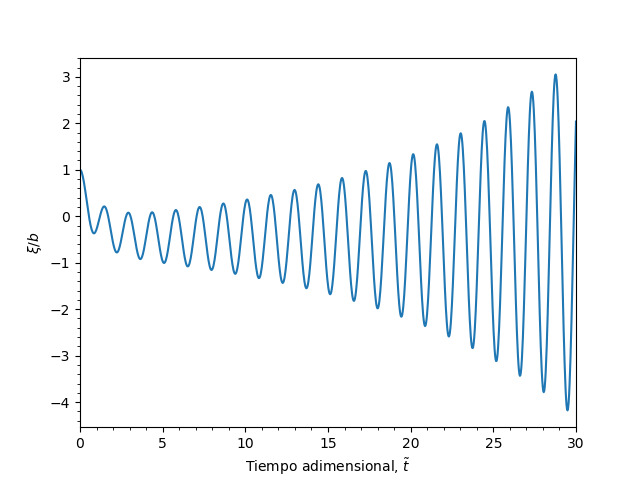

In [304]:
plt.figure()
plt.plot(t,sol[:,0])
plt.xlim(0,30)
plt.xlabel(r'Tiempo adimensional, $\tilde{t}$')
plt.ylabel(r'$\xi/b$')
plt.minorticks_on()

In [286]:
any(fluttera(20,-0.3,0.05,0.5,0.1,0.2)[0]>0)

False

In [4]:
(fluttera(20,-0.3,0.05,0.5,0.1,0.2)[0])

NameError: name 'np' is not defined

In [246]:
flameoA(20,-0.3,0.05,0.5,2.8,0.2,1)[0]

array([-6.52147910+23.33265743j, -6.52147910-23.33265743j,
       -9.07683405 +9.8967649j , -9.07683405 -9.8967649j ,
       -4.99901032 +0.j        , -2.45792838 +0.j        ,
        0.01416183 +0.57896562j,  0.01416183 -0.57896562j,
       -0.59828986 +0.43363305j, -0.59828986 -0.43363305j,
       -0.04835522 +0.j        , -0.10698726 +0.j        ])

In [2]:
def flameo(U0):
    
    b=0.5
    d=-0.25
    m=40
    Sα=10
    Iα=5.83
    Kξ=8000
    Kα=500
    α0=2*np.pi/180
    ρ=1.225
    EI=500
    
    #b,d,m,Sα,Iα,Kξ,Kα,α0,ρ,EI,U0=sp.symbols('b d m Sα Iα Kξ Kα α0 ρ EI U0')

    
    A=np.zeros((12,12))
    B=np.zeros((12,12))
    C=np.zeros(12)
    
    A[0,0]=A[1,1]=B[0,2]=B[1,3]=1
    A[2,2]=m+np.pi*ρ*b**2
    A[3,3]=Iα+np.pi*ρ*(b)**2*(1/8*(b)**2+(d)**2)
    A[3,2]=A[2,3]=Sα-np.pi*ρ*b**2*d
    A[4:,4:]=E(8)[0]
    A[4:,2]=-E(8)[1][:,0]
    A[4:,3]=-E(8)[1][:,0]*(0.5*b-d)
    
    B[2,0]=-Kξ
    B[2,1]=-2*np.pi*ρ*b*U0**2
    B[3,1]=-Kα+2*np.pi*ρ*b*U0**2*(0.5*b+d)
    B[2,2]=-2*np.pi*ρ*b*U0
    B[3,3]=-np.pi*ρ*b**2*U0*(0.5*b-d)+2*np.pi*ρ*b*U0*(0.5*b+d)*(0.5*b-d)
    B[2,4]=2*np.pi*ρ*b*U0
    B[3,4]=-2*np.pi*ρ*b*U0*(0.5*b+d)
    B[2,3]=-np.pi*ρ*b**2*U0-2*np.pi*ρ*b*U0*(0.5*b-d)
    B[3,2]=2*np.pi*ρ*b*U0*(0.5*b+d)
    B[4:,3]=E(8)[1][:,0]*U0
    B[4:,4:]=np.identity(8)*-U0/b
    
    C[3]=Kα*α0
    
    
    
    
    
    return A,la.eig(B,A)
    

In [3]:
flameo(10)[0]

NameError: name 'np' is not defined

In [417]:
any(flameo(16.85)[0]>0)

True

In [190]:
A=flameo(30)[1]
B=flameo(30)[2]
C=flameo(30)[3]

In [198]:
α0=2*np.pi/180

In [206]:
t=np.linspace(0,100,1000)

In [207]:
sol=odeint(f,[0,0,0,0,0,0,0,0,0,0,0,0],t)

In [243]:
def flameoA(m,a,xα,rα,U0a,ωξ,ωα):
 
  
    A=np.zeros((12,12))
    B=np.zeros((12,12))
      
    A[0,0]=A[1,1]=1
    A[2,2]=(1+1/m)
    A[2,3]=A[3,2]=(xα-a/m)
    A[3,3]=((rα)**2+(1/8+(a)**2)/m)
    
    A[4:,4:]=E(8)[0]*U0a*ωα
    A[4:,2]=-(E(8)[1][:,0])
    A[4:,3]=-(E(8)[1][:,0]*(0.5-a))
    
    B[0,2]=B[1,3]=1
    B[2,0]=-(ωξ)**2
    B[2,1]=-2*U0a**2*ωα**2/m
    B[3,1]=-rα**2*ωα**2+2*U0a**2*(0.5+a)*ωα**2/m ###REv    
    B[2,2]=-(2*U0a/m)*ωα
    B[2,3]=-(2*U0a*(1-a)/m)*ωα###### 
    B[3,2]=(2*U0a*(0.5+a)/m)*ωα
    B[3,3]=(2*U0a*(0.5+a)*(0.5-a)/m-(0.5-a)*U0a/m)*ωα
    B[4:,4:]=-np.identity(8)*U0a**2*ωα**2
    B[4:,3]=(U0a*E(8)[1][:,0])*ωα
    
    B[2,4]=(2*U0a**2/m)*ωα**2
    B[3,4]=(-2*U0a**2*(0.5+a)/m)*ωα**2
    
    
    #D=la.inv(A)@B
    return la.eig(B,A)
    #return B

In [239]:
y=np.array([3.4,3.35,3.3,3.1,3.05,3.5,4,5.7])
x=np.array([0,0.2,0.4,0.6,0.7,0.8,0.805,0.82])

In [491]:
Uf=np.linspace(1,3,1000)
wξα=np.linspace(0,1.5,1000)

In [493]:
x=[]
for j in range(len(wξα)):
    for i in range((len(Uf))):
        if any(fluttera(20,-0.3,0.2,0.5,Uf[i],wξα[j])[0].real>0) == True:
            x=np.append(x,Uf[i])
            break
        

In [28]:
b=0.5

In [29]:
x=np.poly1d([1/b,0])

In [278]:
def fluttereta(U0,EI,n):
    
    b=0.5
    d=-0.25
    m=40
    Sα=10
    #EI=500*escala
    Iα=5.83
    Kξ=8000
    Kα=500
    α0=2*np.pi/180
    ρ=1.225
    x=np.poly1d([1/b,0])
    In = np.zeros((n,n))
    Kn = np.zeros((n,n))
    Kξη = np.zeros((n))
    l=np.array([legendre(i+2)(x) for i in range(n)])
    ld=np.array([np.polyder(legendre(i+2)(x),2) for i in range(n)])
    el=np.array([eval_legendre(i+2,d/b) for i in range(n)])
    lT=l[:,np.newaxis]
    ldT=ld[:,np.newaxis]
    elT=el[:,np.newaxis]
    mmm=ldT*ld
    mm=lT*l
    
    for i in range(n):
        Kξη[i]=Kξ*el[i]
        for j in range(n):
            Kn[i,j]=quad(mmm[i][j],-b,b)[0]
            In[i,j]=quad(mm[i][j],-b,b)[0]
            

    
    A=np.zeros((12+2*n,12+2*n))
    B=np.zeros((12+2*n,12+2*n))
    C=np.zeros((14))
    
    A[:(n+2),:(n+2)]=np.identity(n+2)     
    A[2+n,2+n]=m+np.pi*ρ*b**2 
    
    A[2+n,3*n]=A[3+n,2+n]=Sα-np.pi*ρ*b**2*d
    
    A[3+n,3+n]=Iα+np.pi*ρ*b**2*(1/8*b**2+d**2)
    
    A[(4+n):(4+2*n),(4+n):(4+2*n)]=m*In######+np.pi*ρ*b**2/16
    
    
    A[4+2*n:,4*2*n:]=E(8)[0]
    A[4+2*n:,2+n]=-E(8)[1][:,0] 
    A[4+2*n:,3+n]=-E(8)[1][:,0]*(0.5*b-d)   
    
    A[3,5]=A[5,3]=-np.pi*ρ*b**2*1/8
    A[4,5]=A[5,4]=np.pi*ρ*b**2*1/8*d
    
    
    
    
    
    
    
    B[0:3,3:6]=np.identity(3)
    
    B[3,0]=-Kξ
    B[3,1]=-2*np.pi*ρ*b*U0**2
    B[4,1]=-Kα+2*np.pi*ρ*b*U0**2*(0.5*b+d) 
    B[3,3]=-2*np.pi*ρ*b*U0
    
    B[3,4]=-np.pi*ρ*b**2*U0-2*np.pi*ρ*b*U0*(0.5*b-d)  
    
    B[4,3]=2*np.pi*ρ*b*U0*(0.5*b+d)
    
    B[4,4]=2*np.pi*ρ*b*U0*(0.5*b+d)*(0.5*b-d)-np.pi*ρ*b**2*(0.5*b-d)*U0
    
    B[6:,6:]=-np.identity(8)*U0/b
    
    B[6:,4]=U0*E(8)[1][:,0]
    
    B[3,6]=2*np.pi*ρ*b*U0
    B[4,6]=-2*np.pi*ρ*b*U0*(0.5*b+d)
    B[5,6]=np.pi*ρ*b*U0*0.5
    
    B[5,2]=-EI*Kn[0,0]-elT[0]*el[0]*Kξ+3/8*np.pi*ρ*U0**2
    B[5,0]=Kξη[0]
    B[5,1]=-np.pi*b*ρ*U0**2*0.5
    B[4,2]=2*np.pi*ρ*U0**2*(3/2)*d
    B[3,2]=Kξη[0]-3*np.pi*ρ*U0**2
    B[4,5]=2*np.pi*ρ*b*U0*(-b/4+d/4)
    B[5,3]=-np.pi*ρ*b*U0*0.5
    
    B[5,4]=-np.pi*ρ*b*U0*(0.5*b-d)*0.5+np.pi*ρ*b**2*U0*0.5#
    
    B[5,5]=-np.pi*ρ*b*U0/8
    B[3,5]=-2*np.pi*ρ*b*U0/4
    
    C[4]=Kα*α0
    
    
    #return B,Kξη
    return la.eig(B,A)

In [279]:
U=np.linspace(0.1,30,3000)

In [241]:
escala=np.linspace(0.1,10,100)

In [297]:
for i in range(3000):
    if any(fluttereta(U[i],400,2)[0].real>0) == True:
        print(U[i])
        break

25.9721240413


In [197]:
for i in range(300):
    if any(flameo(U[i])[0].real>0) == True:
        print(U[i])
        break
        

25.8


In [17]:
#fluttera(ma,a,xα,rα,U0a,ωξα)
np.savetxt('matrizb',fluttera(20,0,0,0.5,1,1)[1])

In [24]:
DataFrame(fluttera(20,0,0,0.5,1,1)[1])

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.159155,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.159155,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,-0.1,-0.015915,-0.015915,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.2,0.007958,0.000000,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.318310,-1.00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,0.0,0.0,0.000000,0.159155,-0.00,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
6,0.0,0.0,0.000000,0.106103,-0.00,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,0.0,0.0,0.000000,0.079577,-0.00,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0
8,0.0,0.0,0.000000,0.063662,-0.00,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0
9,0.0,0.0,0.000000,0.053052,-0.00,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0
